In [1]:
import duckdb, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuration and connection
DB_PATH = "D:/db/meta.duckdb"                 

con = duckdb.connect(DB_PATH)

con.execute("PRAGMA threads=2;") 
con.execute("SET memory_limit='5GB';") 
con.execute("SET preserve_insertion_order=false;") 

print("\n Set up ready")


 Set up ready


In [7]:
info = con.sql("""PRAGMA table_info(metadata)""").fetchdf()
info['name'].tolist()

['filename',
 'username',
 'like_count',
 'comment_count',
 'width',
 'height',
 'time_utc',
 'caption',
 'aspect_ratio',
 'area',
 'orientation',
 'date_day',
 'dow',
 'hour_utc',
 'has_caption',
 'caption_len_char',
 'month',
 'year',
 'n_hashtags',
 'n_mentions',
 'n_urls',
 'n_emojis',
 'category',
 'followers',
 'followees',
 'posts',
 'engagement_rate',
 'engagement_rate_log']

   year  n_per_year
0  2012        1648
1  2013       10390
2  2014       34904
3  2015      115333
4  2016      506963
5  2017     1776009
6  2018     5160070
7  2019     1961334


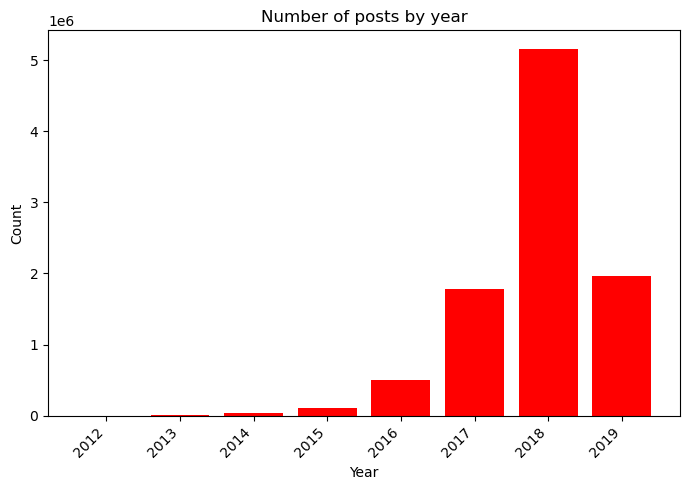

In [20]:
df = con.sql("""
SELECT year, COUNT(*) AS n_per_year
FROM metadata
GROUP BY year
ORDER BY year
""").df() 

print(df)


plt.figure(figsize=(7,5))
plt.bar(df["year"].astype(str), df["n_per_year"], color = 'red')
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of posts by year")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("D:/figures/barplot_per_anno.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
print(con.sql("""
SELECT 
    category, 
    COUNT(DISTINCT username) AS n_users,
    COUNT(*) AS n_posts,
    ROUND(COUNT(DISTINCT username) * 100.0 / SUM(COUNT(DISTINCT username)) OVER(), 2) AS percentage,
    ROUND(AVG(like_count), 2) AS avg_like,
    ROUND(AVG(followers), 2) AS avg_followers,
    ROUND(AVG(engagement_rate), 2) AS avg_ER,
    MIN(engagement_rate) AS min_ER,
    MAX(engagement_rate) AS max_ER,
    ROUND(AVG(n_hashtags), 2) AS avg_hashtags,
    ROUND(AVG(caption_len_char), 2) AS avg_char

FROM metadata1718
GROUP BY category
ORDER BY category;

"""))

┌──────────┬─────────┬─────────┬────────────┬──────────┬───────────────┬────────┬────────┬─────────┬──────────────┬──────────┐
│ category │ n_users │ n_posts │ percentage │ avg_like │ avg_followers │ avg_ER │ min_ER │ max_ER  │ avg_hashtags │ avg_char │
│ varchar  │  int64  │  int64  │   double   │  double  │    double     │ double │ double │ double  │    double    │  double  │
├──────────┼─────────┼─────────┼────────────┼──────────┼───────────────┼────────┼────────┼─────────┼──────────────┼──────────┤
│ beauty   │    1485 │  316699 │       4.56 │  4686.25 │     130466.61 │   4.18 │    0.0 │   481.0 │         8.56 │   327.38 │
│ family   │    3942 │  846285 │      12.11 │   4827.9 │     135891.83 │   4.68 │    0.0 │  818.53 │          7.1 │   359.24 │
│ fashion  │   11563 │ 2490212 │      35.51 │  6166.83 │     179927.53 │   4.88 │    0.0 │ 1136.78 │         6.03 │   249.43 │
│ fitness  │    1091 │  235825 │       3.35 │  5806.35 │     187020.53 │   4.14 │    0.0 │  107.21 │         7.

In [7]:
print(con.sql("""
SELECT 
    category, 
    ROUND(COUNT(DISTINCT username) * 100.0 / SUM(COUNT(DISTINCT username)) OVER(), 2) AS percentage,
    ROUND(AVG(engagement_rate), 2) AS avg_ER
FROM metadata1718
GROUP BY category
ORDER BY category;

"""))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┬────────────┬────────┐
│ category │ percentage │ avg_ER │
│ varchar  │   double   │ double │
├──────────┼────────────┼────────┤
│ beauty   │       4.56 │   4.18 │
│ family   │      12.11 │   4.68 │
│ fashion  │      35.51 │   4.88 │
│ fitness  │       3.35 │   4.14 │
│ food     │      10.52 │   3.66 │
│ interior │       3.59 │   3.53 │
│ other    │      16.02 │   3.48 │
│ pet      │       1.73 │   4.76 │
│ travel   │      12.61 │   5.14 │
└──────────┴────────────┴────────┘



   category  percentage  avg_ER
0   fashion       35.51    4.88
1     other       16.02    3.48
2    travel       12.61    5.14
3    family       12.11    4.68
4      food       10.52    3.66
5    beauty        4.56    4.18
6  interior        3.59    3.53
7   fitness        3.35    4.14
8       pet        1.73    4.76


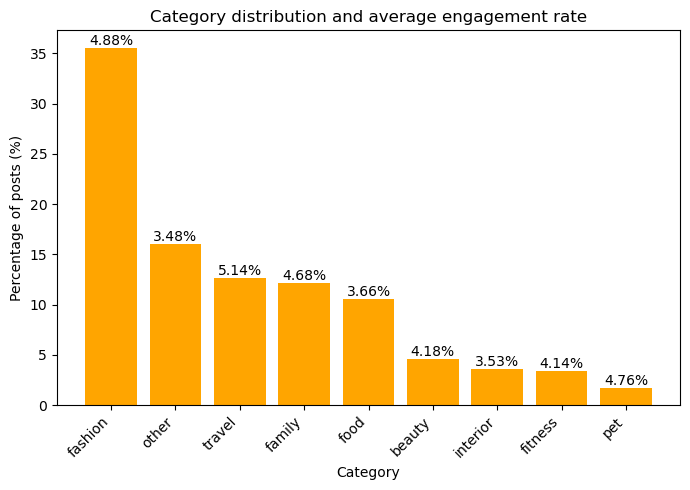

In [19]:
df = con.sql("""
SELECT 
    category, 
    ROUND(COUNT(DISTINCT username) * 100.0 / SUM(COUNT(DISTINCT username)) OVER(), 2) AS percentage,
    ROUND(AVG(engagement_rate), 2) AS avg_ER
FROM metadata1718
GROUP BY category
ORDER BY percentage DESC;
""").df()

print(df)

df = df.sort_values("percentage", ascending=False).reset_index(drop=True)

plt.figure(figsize=(7, 5))
bars = plt.bar(df["category"].astype(str), df["percentage"], color = 'orange')

plt.xlabel("Category")
plt.ylabel("Percentage of posts (%)")
plt.title("Category distribution and average engagement rate")

for bar, avg_er in zip(bars, df["avg_ER"]):
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{avg_er}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("D:/figures/category_distribition_er.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
print(con.sql("""
SELECT 
    category, year,
    COUNT(DISTINCT username) AS n_users,
    COUNT(*) AS n_posts,
    ROUND(COUNT(DISTINCT username) * 100.0 / SUM(COUNT(DISTINCT username)) OVER(PARTITION BY year), 2) AS percentage,
    ROUND(AVG(like_count), 2) AS avg_like,
    ROUND(AVG(followers), 2) AS avg_followers,
    ROUND(AVG(engagement_rate), 2) AS avg_ER,
    MIN(engagement_rate) AS min_ER,
    MAX(engagement_rate) AS max_ER,
    ROUND(AVG(n_hashtags), 2) AS avg_hashtags,
    ROUND(AVG(caption_len_char), 2) AS avg_char
FROM metadata
WHERE year in (2017, 2018)
GROUP BY category, year
ORDER BY 1, 2;

"""))

┌──────────┬───────┬─────────┬─────────┬────────────┬──────────┬───────────────┬────────┬────────┬─────────┬──────────────┬──────────┐
│ category │ year  │ n_users │ n_posts │ percentage │ avg_like │ avg_followers │ avg_ER │ min_ER │ max_ER  │ avg_hashtags │ avg_char │
│ varchar  │ int64 │  int64  │  int64  │   double   │  double  │    double     │ double │ double │ double  │    double    │  double  │
├──────────┼───────┼─────────┼─────────┼────────────┼──────────┼───────────────┼────────┼────────┼─────────┼──────────────┼──────────┤
│ beauty   │  2017 │    1067 │   94764 │       5.28 │  3689.31 │     107524.29 │   3.65 │    0.0 │   481.0 │         7.42 │   278.35 │
│ beauty   │  2018 │    1485 │  221935 │       4.56 │  5111.93 │     140262.75 │   4.41 │    0.0 │  461.05 │         9.05 │   348.14 │
│ family   │  2017 │    2446 │  207454 │       12.1 │  4225.87 │     118344.49 │   4.37 │    0.0 │  359.67 │          5.8 │   266.99 │
│ family   │  2018 │    3938 │  638831 │       12.1 │  

In [3]:
time = con.sql("""SELECT time_utc, like_count, comment_count FROM metadata1718""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
def add_value_labels_line(ax, x, y, fmt="{:.0f}", fontsize=11, offset=(0, 6)):
    for xi, yi in zip(x, y):
        ax.annotate(
            fmt.format(yi),
            (xi, yi),
            textcoords="offset points",
            xytext=offset,
            ha="center",
            fontsize=fontsize
        )


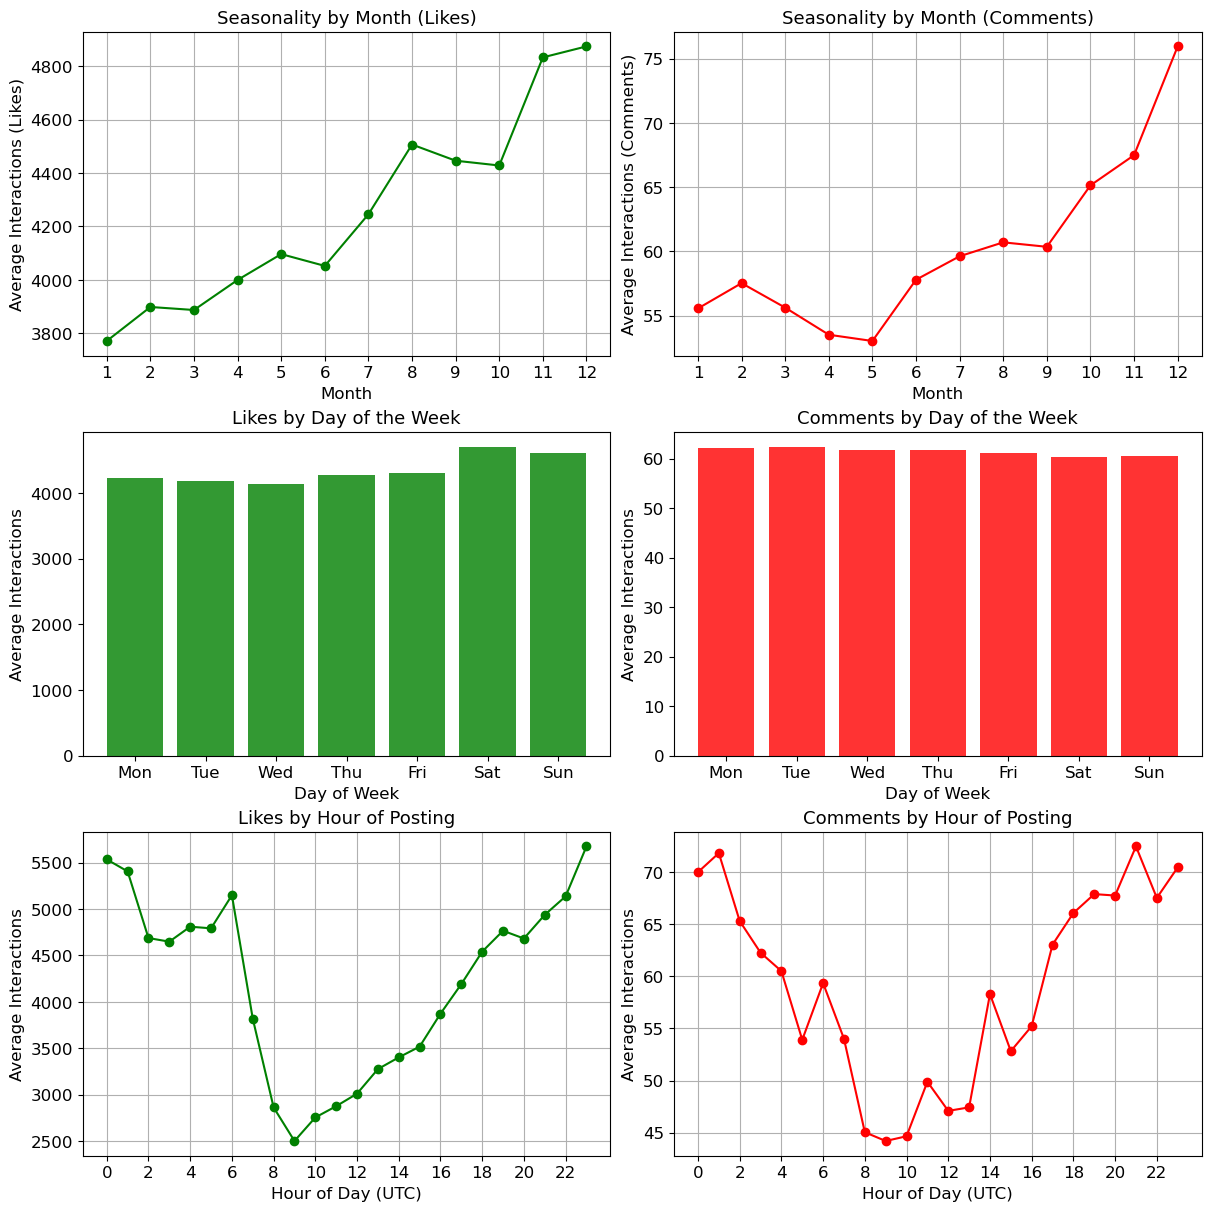

In [13]:
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

outdir = "D:/figures"
os.makedirs(outdir, exist_ok=True)

# Aggregation
likes_month = time.groupby(time['time_utc'].dt.month)['like_count'].mean()
comments_month = time.groupby(time['time_utc'].dt.month)['comment_count'].mean()

likes_wd = time.groupby(time['time_utc'].dt.dayofweek)['like_count'].mean()
comments_wd = time.groupby(time['time_utc'].dt.dayofweek)['comment_count'].mean()

likes_hour = time.groupby(time['time_utc'].dt.hour)['like_count'].mean()
comments_hour = time.groupby(time['time_utc'].dt.hour)['comment_count'].mean()

fig, axs = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True)

# Month
axs[0, 0].plot(likes_month.index, likes_month.values, marker='o', color='green')
axs[0, 0].set_xticks(range(1, 13))
axs[0, 0].set_xlabel("Month")
axs[0, 0].set_ylabel("Average Interactions (Likes)")
axs[0, 0].set_title("Seasonality by Month (Likes)")
axs[0, 0].grid(True)

axs[0, 1].plot(comments_month.index, comments_month.values, marker='o', color='red')
axs[0, 1].set_xticks(range(1, 13))
axs[0, 1].set_xlabel("Month")
axs[0, 1].set_ylabel("Average Interactions (Comments)")
axs[0, 1].set_title("Seasonality by Month (Comments)")
axs[0, 1].grid(True)

# Day of the week
weekday_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

axs[1, 0].bar(likes_wd.index, likes_wd.values, alpha=0.8, color='green')
axs[1, 0].set_xticks(range(7))
axs[1, 0].set_xticklabels(weekday_labels)
axs[1, 0].set_xlabel("Day of Week")
axs[1, 0].set_ylabel("Average Interactions")
axs[1, 0].set_title("Likes by Day of the Week")

axs[1, 1].bar(comments_wd.index, comments_wd.values, alpha=0.8, color='red')
axs[1, 1].set_xticks(range(7))
axs[1, 1].set_xticklabels(weekday_labels)
axs[1, 1].set_xlabel("Day of Week")
axs[1, 1].set_ylabel("Average Interactions")
axs[1, 1].set_title("Comments by Day of the Week")

# Hour
axs[2, 0].plot(likes_hour.index, likes_hour.values, marker='o', color='green')
axs[2, 0].set_xticks(range(0, 24, 2))  # meno affollato di 0..23
axs[2, 0].set_xlabel("Hour of Day (UTC)")
axs[2, 0].set_ylabel("Average Interactions")
axs[2, 0].set_title("Likes by Hour of Posting")
axs[2, 0].grid(True)

axs[2, 1].plot(comments_hour.index, comments_hour.values, marker='o', color='red')
axs[2, 1].set_xticks(range(0, 24, 2))
axs[2, 1].set_xlabel("Hour of Day (UTC)")
axs[2, 1].set_ylabel("Average Interactions")
axs[2, 1].set_title("Comments by Hour of Posting")
axs[2, 1].grid(True)

fig.savefig(os.path.join(outdir, "seasonality.png"), dpi=300, bbox_inches="tight")
fig.savefig(os.path.join(outdir, "seasonality.pdf"), bbox_inches="tight")
plt.show()

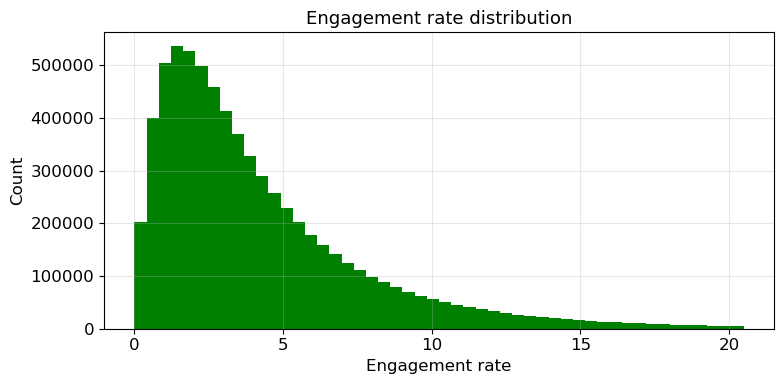

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

er = con.sql("SELECT engagement_rate FROM metadata1718").fetchdf()

s = (pd.to_numeric(er["engagement_rate"], errors="coerce")
     .replace([np.inf, -np.inf], np.nan)
     .dropna())

s = s[s >= 0]

q = 0.99
thr = s.quantile(q)
s_zoom = s[s <= thr]

plt.figure(figsize=(8,4))
plt.hist(s_zoom, bins=50, density=False, color = 'green')
plt.xlabel(f"Engagement rate")
plt.ylabel("Count")
plt.title("Engagement rate distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "er_distribution.png"), dpi=300, bbox_inches="tight")
plt.show()

In [32]:
con.close()